<a href="https://colab.research.google.com/github/hyunicecream/ML-DL/blob/main/%EB%8B%A8%EB%B0%A9%ED%96%A5%20Many%20to%20One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 2차원 배열의 feature 데이터로 LSTM 학습 데이터 만들기.
def build_train_data(data, t_step, n_jump = 1):
    n_data = data.shape[0]   # number of data
    n_feat = data.shape[1]   # number of features

    m = np.arange(0, n_data - t_step, n_jump)   # m =  [0, 1, 2, 3, 4, 5]
    x = [data[i:(i+t_step), :] for i in m]      # feature data
    y = [data[i, :] for i in (m + t_step)]      # target data

    # shape을 조정한다. feature = 3D, target = 2D
    x_data = np.reshape(np.array(x), (len(m), t_step, n_feat))
    y_target = np.reshape(np.array(y), (len(m), n_feat))
    
    return x_data, y_target

In [ ]:
# 시계열 데이터 (noisy sin)
sine = np.sin(2 * np.pi * 0.03 * np.arange(1001)) # sine곡선
# sine = np.sin(2 * np.pi * 0.03 * np.arange(1001)) + np.random.random(1001) # trend & noisy sine

In [ ]:
# 데이터가 데이터프레임 형식으로 되어 있다고 생각하자. feature가 1개이고 target이 없는 데이터임.
# 미래의 sine 값을 target으로 만들어 주고, LSTM을 학습한다.
df = pd.DataFrame({'sine':sine})
df.head()

,sine
0,0.000000
1,0.187381
2,0.368125
3,0.535827
4,0.684547


In [ ]:
# 학습 데이터 생성
data = np.array(df)
t_step = 20
x_train, y_train = build_train_data(data, t_step)
x_train.shape, y_train.shape

((981, 20, 1), (981, 1))

In [ ]:
n_input = 1
n_output = 1
n_hidden = 50

# LSTM 모델을 생성한다.
x_input = Input(batch_shape=(None, t_step, n_input))
# None: 데이터 미정 (데이터가 없다는 뜻이 아니다) 데이터가 아직 결정된 바가 없다. 
# 그래서 fit()과 predict() 데이터가 들어오면 그때 알 수 있다. 
x_lstm = LSTM(n_hidden)(x_input)
#x_lstm, last_h, last_c = LSTM(n_hidden, return_sequences=True, return_state=True)(x_input)
# return_sequences=True 중간출력을 모두 한다. -> many to many 변환
# return_state=True h, c를 출력한다. -> many to many 변환
# y_pred[0] = x_lstm
# y_pred[1] = last_h
# y_pred[2] = last_c
y_output = Dense(n_output)(x_lstm)

model = Model(x_input, y_output)
model.compile(loss='mse', optimizer=Adam(learning_rate = 0.001))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 학습한다
h = model.fit(x_train, y_train, epochs=20, batch_size=100, shuffle=True)

Epoch 1/20
10/10 [==============================] - 3s 16ms/step - loss: 0.3591
Epoch 2/20
10/10 [==============================] - 0s 16ms/step - loss: 0.1168
Epoch 3/20
10/10 [==============================] - 0s 17ms/step - loss: 0.0188
Epoch 4/20
10/10 [==============================] - 0s 17ms/step - loss: 0.0080
Epoch 5/20
10/10 [==============================] - 0s 20ms/step - loss: 0.0026
Epoch 6/20
10/10 [==============================] - 0s 19ms/step - loss: 9.1494e-04
Epoch 7/20
10/10 [==============================] - 0s 16ms/step - loss: 5.8414e-04
Epoch 8/20
10/10 [==============================] - 0s 18ms/step - loss: 1.8744e-04
Epoch 9/20
10/10 [==============================] - 0s 16ms/step - loss: 1.0399e-04
Epoch 10/20
10/10 [==============================] - 0s 17ms/step - loss: 7.4574e-05
Epoch 11/20
10/10 [==============================] - 0s 17ms/step - loss: 5.5246e-05
Epoch 12/20
10/10 [==============================] - 0s 21ms/step - loss: 4.9271e-05
Epoch 13/

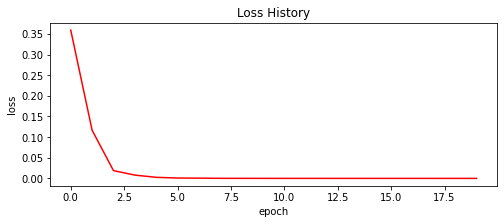

In [ ]:
# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
# 최근 t_step 기간의 데이터로 다음 기간의 sine 값을 예측한다.
px = data[-t_step:].reshape(1, t_step, 1)
y_pred = model.predict(px)[0][0]
print(y_pred) # t= 1 일때의 출력 [0][0][0]
# y_pred[1][0][-1] = y_pred[1][0]

0.19152606


In [ ]:
# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
n_future = 20
n_last = 100
if len(data) > n_last:
    last_data = np.copy(data[-n_last:])  # 원 데이터의 마지막 n_last개만 그려본다
else:
    last_data = np.copy(data)

dx = np.copy(last_data)
estimated = [dx[-1][0]]
for i in range(n_future):
    # 마지막 t_step 만큼 입력데이터로 다음 값을 예측한다
    px = dx[-t_step:].reshape(1, t_step, 1)
    
    # 다음 값을 예측한다.
    y_hat = model.predict(px)[0][0]
        
    # 예측값을 저장해 둔다
    estimated.append(y_hat)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    dx = np.insert(dx, len(dx), y_hat)


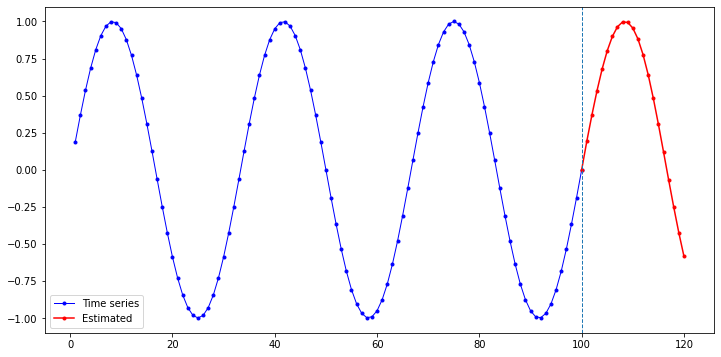

In [ ]:
# 원 시계열과 예측된 시계열을 그린다
plt.figure(figsize=(12, 6))
ax1 = np.arange(1, len(last_data) + 1)
ax2 = np.arange(len(last_data), len(last_data) + len(estimated))
plt.plot(ax1, last_data, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, estimated, 'b-o', color='red', markersize=3, label='Estimated')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()